In [1]:
%load_ext autoreload
%autoreload 2

# Functions

In [2]:
def plot_examples(ds, model1, model2, model3, n=4):
    """Plot some example segmentations"""

    indices = random.sample(range(len(ds)),n)
    
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred1 = model1(x[None].cuda())[0].cpu()
            y_pred2 = model2(x[None].cuda())[0].cpu()
            y_pred3 = model3(x[None].cuda())[0].cpu() 
                       
        
        x = x*0.2347+0.4394
        
        y_pred1 = torch.max(y_pred1, dim=0)[1]
        y_pred2 = torch.max(y_pred2, dim=0)[1]
        y_pred3 = torch.max(y_pred3, dim=0)[1]
        
        iou1 = perf_funcs.segmentation_accuracy(y_pred1, y[None], meas = ['iou'])
        iou2 = perf_funcs.segmentation_accuracy(y_pred2, y[None], meas = ['iou'])
        iou3 = perf_funcs.segmentation_accuracy(y_pred3, y[None], meas = ['iou'])
    
        plt.figure(figsize=[20,5])a
        plt.subplot(1, 6, 1)
        plt.imshow(x_or.permute(1, 2, 0), 'gray')
        plt.title('Original image')
        plt.subplot(1, 6, 2)
        plt.imshow(x.permute(1, 2, 0), 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 6, 3)
        plt.imshow(y==1, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 6, 4)
        plt.imshow(y_pred1, 'gray')
        plt.title(f'Pred Model 1 \niou: {iou1.numpy():.2f}')
        plt.subplot(1, 6, 5)
        plt.imshow(y_pred2, 'gray')
        plt.title(f'Pred Model 2 \niou: {iou2.numpy():.2f}')
        plt.subplot(1, 6, 6)
        plt.imshow(y_pred3, 'gray')
        plt.title(f'Pred Model 3 \niou: {iou3.numpy():.2f}')
        plt.show()



SyntaxError: invalid syntax (3638830253.py, line 25)

In [3]:
# Functions
def get_image_label_prediction(model, dataset, img_idx):
    """
    Obtains the original image, equalized image, label, filename, and prediction for a given image index.

    Parameters
    ----------
        * model (torch.nn.Module): The model used for prediction.
        * dataset (torch.utils.data.Dataset): The dataset containing the images.
        * img_idx (int): The index of the image to retrieve.

    Returns
    -------
        * img_or (numpy.ndarray): The original image.
        * img_equalized (numpy.ndarray): The equalized image.
        * label (int): The label of the image.
        * filename (str): The filename of the image.
        * pre/d (torch.Tensor): The prediction of the model for the image.
    """
    # Get original image from dataset
    img_or, _ = dataset.get_item(img_idx)
    img_or = np.array(img_or)
    # Get equalized image and its label
    img_equalized, label = dataset[img_idx]
    # Get filename
    filename = dataset.img_file_paths[img_idx].stem

    # Prediction
    with torch.no_grad():
        pred = model(img_equalized[None].to('cuda')).cpu()

    return img_or, img_equalized, label, filename, pred

def get_inference_iou(model, dataset):
    """
    Calculates the Intersection over Union (IoU) for each image in the dataset.

    Parameters
    ----------
        * model (object): The trained model used for prediction.
        * dataset (object): The dataset containing the images and labels.

    Returns
    -------
        * prediction_summary (DataFrame): A DataFrame containing the image index and the corresponding IoU.
    """
    # Define columns names
    columns_ = ['img_idx', 'prediction_iou']
    # Create dataframe
    prediction_summary = pd.DataFrame(columns = columns_)
    # Get dataset len
    dataset_len = len(dataset)

    for img_idx in range(dataset_len):

        img_or, img_equalized, label, filename, pred = get_image_label_prediction(model, dataset, img_idx)
        iou = perf_funcs.segmentation_accuracy(pred, label[None], meas = 'iou')

        # A dictionary to store the data
        results_dict = {
            "img_idx" : img_idx,
            "prediction_iou" : iou.numpy(),
        }

        # Convert the dict to dataframe
        df_result = pd.DataFrame([results_dict])
        # Concact df_result with prediction_summary to append a new row
        prediction_summary = pd.concat([prediction_summary, df_result])

    # Reset indexes
    prediction_summary.reset_index(drop = True, inplace = True)

    return prediction_summary




In [4]:
def load_model_with_checkpoint(checkpoint_path, model):
    """
    Loads a PyTorch model with a checkpoint.

    Parameters
    ----------
        * checkpoint_path (str): The path to the checkpoint file.
        * model (nn.Module): The PyTorch model to load the checkpoint into.

    Returns
    -------
        * nn.Module: The PyTorch model with the loaded checkpoint.
    """
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))

    # Extract the state dictionary from the checkpoint
    state_dict = checkpoint['state_dict']

    # Create a new dictionary to store the model state
    new_state_dict = {}

    # Iterate over each item in the state dictionary
    for k, v in state_dict.items():
        # If the item's key starts with 'model.', remove this prefix from the key
        # and add the item to the new state dictionary
        if k.startswith('model.'):
            new_state_dict[k[6:]] = v

    # Load the model state from the new state dictionary
    model.load_state_dict(new_state_dict)

    # Put the model in evaluation mode
    model.eval()
    model.cuda()

    return model

# Training

In [5]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import torch

import train_thin_regions_lightning as train_lightning
import dataset_thin_region as dataset
import torchtrainer

import torchtrainer.models.resunet as resunet
from torchtrainer import perf_funcs

import pandas as pd
import numpy as np
import plotly.express as px

import segmentation_models_pytorch as smp

In [6]:
model = smp.FPN(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [7]:
%%time


img_path = '/home/wesleygalvao/Documents/repositorios/thin-object-selection/data/ThinObject5K_fine_tuning/images'
label_path = '/home/wesleygalvao/Documents/repositorios/thin-object-selection/data/ThinObject5K_fine_tuning/masks'

params = {
    # Dataset
    'img_dir': Path(img_path),
    'label_dir': Path(label_path),
    'crop_size': (256, 256),
    'train_val_split': 0.1,
    # Model
    'model_layers': (3,3,3,3),
    'model_channels': (16,32,64,128),
    'model_type': 'resnet18_fpn',
    # Training
    'epochs': 50,
    'lr': 0.01,
    'batch_size_train': 1,
    'batch_size_valid': 1, #132,
    'momentum': 0.9,
    'weight_decay': 0.01, # Peso de regularização ex: 0.01 
    'seed': 12,
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,
    'class_weights': (0.0670, 0.9330), # Serve para reponderar os pesos das classes
    # Type of normalization. Options: 'batch_norm', 'group_norm'
    'normalization_layer': 'group_norm',
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,  # 3 is a good compromise
    'use_amp': False,
    'pin_memory': False,
    'non_blocking': False,
    # Logging
    'log_dir': 'logs',
    'experiment':'resnet18_fpn_e_50_lr_0.01_bs_1',
    'save_every':1,
    'save_best':True,
    # Other
    'resume': False,
    'meta': None, 
}



CPU times: user 169 µs, sys: 42 µs, total: 211 µs
Wall time: 28.6 µs


In [8]:
%%time
#Train using pure Pytorch
#logger, ds_train, ds_valid, model = train_pytorch.run(params)
#Train using Pytorch Lightning
trainer, ds_train, ds_valid, model = train_lightning.run(params)
logger = trainer.loggers[1]

Seed set to 12
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | loss_func | CrossEntropyLoss | 0     
1 | model     | FPN              | 13.0 M
-----------------------------------------------
13.0 M    Trainable params
0         Non-trainable params
13.0 M    Total params
52.189    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 11h 18min 2s, sys: 34min 56s, total: 11h 52min 59s
Wall time: 11h 53min 4s


# View results

## Training logs

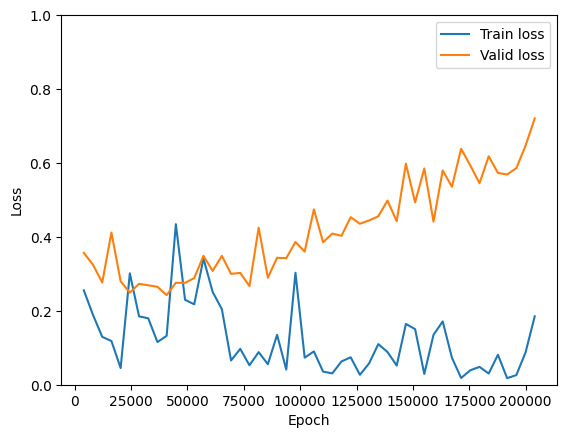

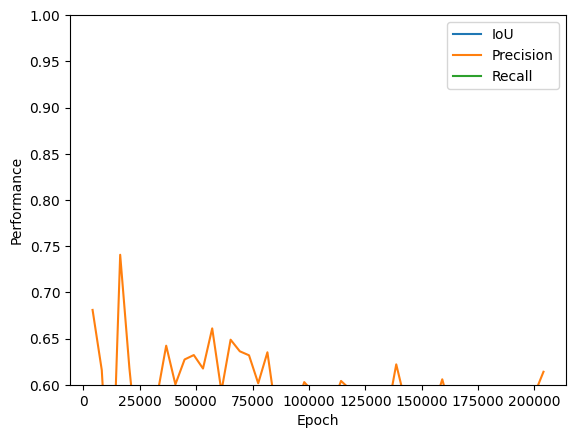

In [9]:
# Plot results
def plot_metrics(logger, type='lt'):
    '''Plot losses and IoU. `lt` is the logger used in Lightning.'''

    if type=='lt':
        metrics = logger.metrics
        epochs, _ = zip(*metrics['val_loss'])
        metrics = [list(zip(*metrics[k]))[1] for k in ['train_loss', 'val_loss', 'iou', 'prec', 'rec']]
        train_loss, valid_loss, iou, prec, rec = metrics    
    elif type=='pt':
        epochs, metrics = zip(*logger.data.items())
        train_loss, valid_loss, iou, prec, rec = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.ylim((0, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.ylim((0.6, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')
    
plot_metrics(logger, type='lt')

## Visual Evaluation

In [9]:
def load_model_with_checkpoint(checkpoint_path, model):
    """
    Loads a PyTorch model with a checkpoint.

    Parameters
    ----------
        * checkpoint_path (str): The path to the checkpoint file.
        * model (nn.Module): The PyTorch model to load the checkpoint into.

    Returns
    -------
        * nn.Module: The PyTorch model with the loaded checkpoint.
    """
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))

    # Extract the state dictionary from the checkpoint
    state_dict = checkpoint['state_dict']

    # Create a new dictionary to store the model state
    new_state_dict = {}

    # Iterate over each item in the state dictionary
    for k, v in state_dict.items():
        # If the item's key starts with 'model.', remove this prefix from the key
        # and add the item to the new state dictionary
        if k.startswith('model.'):
            new_state_dict[k[6:]] = v

    # Load the model state from the new state dictionary
    model.load_state_dict(new_state_dict)

    # Put the model in evaluation mode
    model.eval()
    model.cuda()

    return model



In [53]:
checkpoint1_path = './logs/resunet18_fpn_e_50_lr_0.01_bs_1/checkpoints/best_val_loss-epoch=09-val_loss=0.24.ckpt' 
checkpoint2_path = './logs/resnet18_fpn_e_50_lr_0.01_bs_1/checkpoints/best_val_loss-epoch=02-val_loss=0.44.ckpt'



model_init = smp.FPN(
                encoder_name="resnet18",        
                encoder_weights="imagenet",     
                in_channels=3,                  
                classes=2,                      
)


model1 = load_model_with_checkpoint(checkpoint1_path, model_init)
model2 = load_model_with_checkpoint(checkpoint2_path, model_init)

# model.load_state_dict(state_dict)



In [32]:
def plot_examples(ds, model1, model2,  n=4):
    """Plot some example segmentations"""

    indices = random.sample(range(len(ds)),n)
    
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        
        # Pad the image to be divisible by 32
        h, w = x.shape[1:]
        new_h = ((h - 1) // 32 + 1) * 32
        new_w = ((w - 1) // 32 + 1) * 32
        padding_h = new_h - h
        padding_w = new_w - w
        x = torch.nn.functional.pad(x, (0, padding_w, 0, padding_h), mode='constant', value=0)
        
        with torch.no_grad():
            y_pred1 = model1(x[None].cuda())[0].cpu()
            y_pred2 = model2(x[None].cuda())[0].cpu()

                       
        
        x = x*0.2347+0.4394
        
        y_pred1 = torch.max(y_pred1, dim=0)[1]
        y_pred2 = torch.max(y_pred2, dim=0)[1]

        
        # iou1 = perf_funcs.segmentation_accuracy(y_pred1, y[None], meas = ['iou'])
        # iou2 = perf_funcs.segmentation_accuracy(y_pred2, y[None], meas = ['iou'])

    
        plt.figure(figsize=[20,5])
        plt.subplot(1, 5, 1)
        plt.imshow(x_or.permute(1, 2, 0), 'gray')
        plt.title('Original image')
        plt.subplot(1, 5, 2)
        plt.imshow(x.permute(1, 2, 0), 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 5, 3)
        plt.imshow(y==1, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 5, 4)
        plt.imshow(y_pred1, 'gray')
        plt.title(f'Pred Model 1')
        plt.subplot(1, 5, 5)
        plt.imshow(y_pred2, 'gray')
        plt.title(f'Pred Model 2')
        plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


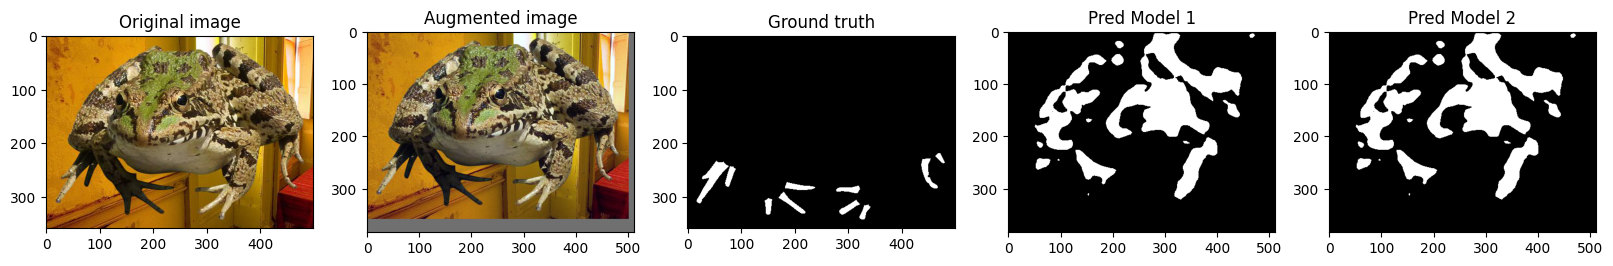

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


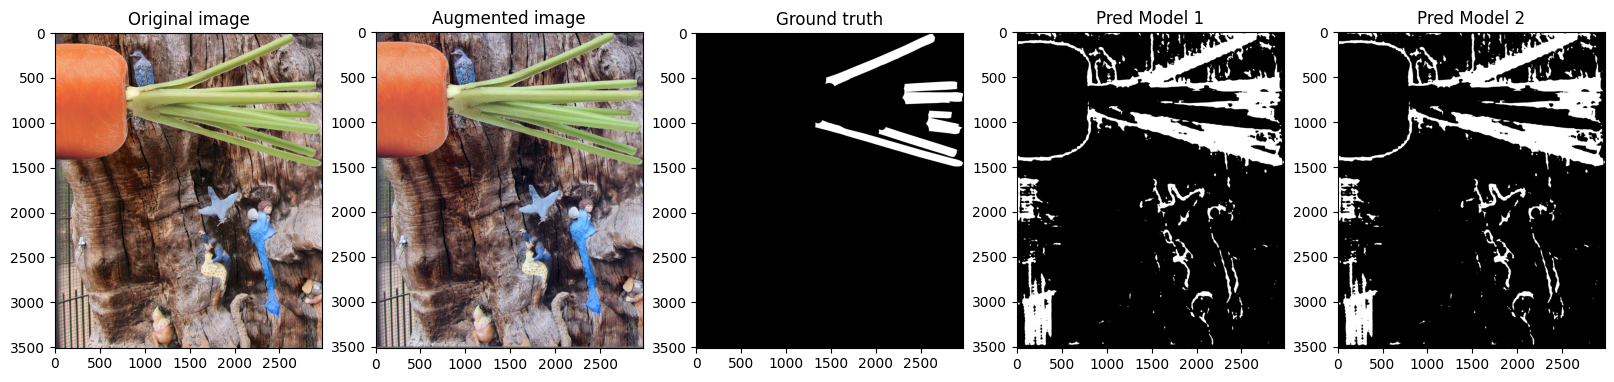

In [60]:
plot_examples(ds_valid, model1, model2, n=2)

In [32]:
# Assuming you have a module named performance_metrics_functions

def plot_examples(ds, model1, n=4):
    """Plot some example segmentations"""

    indices = random.sample(range(len(ds)), n)
    
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        
        # Pad the image to be divisible by 32
        h, w = x.shape[1:]
        new_h = ((h - 1) // 32 + 1) * 32
        new_w = ((w - 1) // 32 + 1) * 32
        padding_h = new_h - h
        padding_w = new_w - w
        x = torch.nn.functional.pad(x, (0, padding_w, 0, padding_h), mode='constant', value=0)
        
        with torch.no_grad():
            y_pred1 = model1(x[None].cuda())[0].cpu()
          
        
        x = x * 0.2347 + 0.4394
        
        y_pred1 = torch.max(y_pred1, dim=0)[1]    
        
        # iou1 = perf_funcs.segmentation_accuracy(y_pred1, y[None], meas=['iou'])

    
        plt.figure(figsize=[20, 5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or.permute(1, 2, 0), 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x.permute(1, 2, 0), 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y == 1, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred1, 'gray')
        # plt.title(f'Pred Model 1 \niou: {iou1.numpy():.2f}')
        plt.show()


In [28]:
plot_examples(ds_valid, model1, n=2)

TypeError: plot_examples() missing 1 required positional argument: 'model2'